# Lecture 8 - Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Explain a simple multilayer perceptron: layers, weights, bias, activation, loss, optimizer.
- Build your first neural network for a toy problem, then for small chemistry tasks.
- Use `StandardScaler` and why scaling matters.
- Train `MLPRegressor` and `MLPClassifier` step by step with diagnostics.
- Read training curves, avoid overfitting with `alpha` and `early_stopping`.
- Connect to our C-H dataset from earlier lectures.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1yOqj6y2X1nYd6m2R1eQ3Q2YkzNNNNNN?usp=sharing)

---

## 0. Setup

We will stick to a light stack so it runs everywhere.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

# RDKit optional
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

---

## 1. What is a neural network

```{admonition} Picture in words
A multilayer perceptron (MLP) takes an input vector x, multiplies by a weight matrix, adds a bias, applies a nonlinear activation like ReLU or tanh, then repeats for one or more hidden layers, and finally outputs a number (regression) or class score (classification).
```

Key pieces:

- **Weights `W` and bias `b`** set how features combine.
- **Activation** makes the model nonlinear so it can bend decision boundaries.
- **Loss** measures error. We update weights to reduce loss on the training set.
- **Optimizer** uses gradients to move weights a little bit each iteration (epoch).

We start tiny with a synthetic dataset so we can see each piece clearly.

---

## 2. Tiny 2D classification: baseline then MLP

We will sample two clouds that are not linearly separable. A straight line will struggle. A small MLP should improve.

### 2.1 Generate a toy dataset and plot

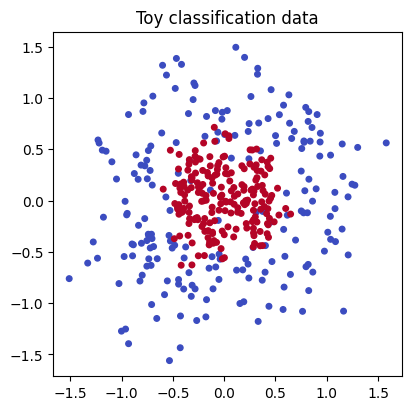

In [2]:
rng = np.random.RandomState(0)

n = 200
theta = rng.uniform(0, 2*np.pi, size=n)
r = 1.0 + 0.3*rng.randn(n)
X1 = np.c_[r*np.cos(theta), r*np.sin(theta)]
y1 = np.zeros(n, dtype=int)

theta2 = rng.uniform(0, 2*np.pi, size=n)
r2 = 0.4 + 0.15*rng.randn(n)
X2 = np.c_[r2*np.cos(theta2), r2*np.sin(theta2)]
y2 = np.ones(n, dtype=int)

X_toy = np.vstack([X1, X2])
y_toy = np.hstack([y1, y2])

plt.figure(figsize=(4.5,4.5))
plt.scatter(X_toy[:,0], X_toy[:,1], c=y_toy, cmap="coolwarm", s=16)
plt.gca().set_aspect("equal")
plt.title("Toy classification data")
plt.show()

### 2.2 Split and try a linear model

```{admonition} Why a baseline
As in past lectures, a simple baseline tells us if a complex model is truly needed.
```

In [3]:
Xtr, Xte, ytr, yte = train_test_split(X_toy, y_toy, test_size=0.25, random_state=42, stratify=y_toy)

lin = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])
lin.fit(Xtr, ytr)

acc_lin = accuracy_score(yte, lin.predict(Xte))
print(f"Linear baseline accuracy: {acc_lin:.3f}")

Linear baseline accuracy: 0.520


### 2.3 Build a small MLP step by step

We will add one hidden layer with 8 units and ReLU activation.

In [4]:
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(8,),
                          activation="relu",
                          learning_rate_init=0.05,
                          alpha=1e-4,            # L2 penalty
                          max_iter=500,
                          random_state=0))
])
mlp

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(8,), learning_rate_init=0.05,
                               max_iter=500, random_state=0))])

Fit and evaluate.

In [5]:
mlp.fit(Xtr, ytr)
acc_mlp = accuracy_score(yte, mlp.predict(Xte))
print(f"MLP accuracy: {acc_mlp:.3f}")

MLP accuracy: 0.940


Peek at the learned shapes.

In [6]:
clf = mlp.named_steps["clf"]
print("Number of layers (including input and output):", clf.n_layers_)
print("Hidden layer sizes:", clf.hidden_layer_sizes)
print("coefs_ length:", len(clf.coefs_))
print("Layer 1 weight matrix shape:", clf.coefs_[0].shape)  # (n_features, n_hidden)
print("Layer 2 weight matrix shape:", clf.coefs_[1].shape)  # (n_hidden, n_classes)

Number of layers (including input and output): 3
Hidden layer sizes: (8,)
coefs_ length: 2
Layer 1 weight matrix shape: (2, 8)
Layer 2 weight matrix shape: (8, 1)


Plot a decision surface to see the boundary.

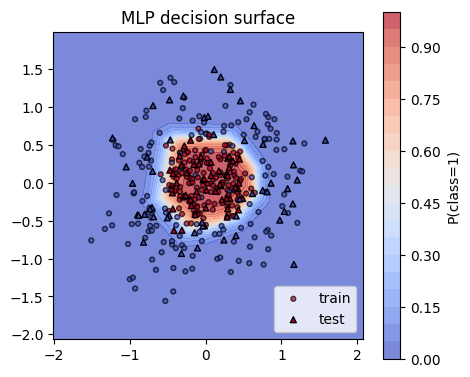

In [7]:
# grid
xx, yy = np.meshgrid(np.linspace(X_toy[:,0].min()-0.5, X_toy[:,0].max()+0.5, 200),
                     np.linspace(X_toy[:,1].min()-0.5, X_toy[:,1].max()+0.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = mlp.predict_proba(grid)[:,1].reshape(xx.shape)

plt.figure(figsize=(5,4.5))
cs = plt.contourf(xx, yy, zz, levels=20, alpha=0.7, cmap="coolwarm")
plt.colorbar(cs, label="P(class=1)")
plt.scatter(Xtr[:,0], Xtr[:,1], c=ytr, cmap="coolwarm", s=12, edgecolor="k", alpha=0.7, label="train")
plt.scatter(Xte[:,0], Xte[:,1], c=yte, cmap="coolwarm", s=18, marker="^", edgecolor="k", label="test")
plt.legend(loc="lower right")
plt.gca().set_aspect("equal")
plt.title("MLP decision surface")
plt.show()

```{admonition} Reading the picture
Color near 0 is class 0 and near 1 is class 1. A curved boundary shows that the hidden layer and activation created a nonlinear rule.
```

**Exercises 2.x**

1. Change `hidden_layer_sizes=(16,)` then `(16,8)` and compare test accuracy.
2. Switch `activation` from `"relu"` to `"tanh"` and rerun. Which works better here and why might that be?
3. Change `learning_rate_init` to `0.005` then `0.2`. Watch whether the model converges. If it stalls, raise `max_iter`.
4. Remove the scaler from the pipeline and fit again. Record the accuracy. What changed?

---

## 3. Connect to chemistry: load C-H dataset and build descriptors

We reuse the same CSV from earlier lectures and compute four quick descriptors.

In [8]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


In [9]:
def calc_desc(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m)
    })

desc = df_raw["SMILES"].apply(calc_desc)
df = pd.concat([df_raw, desc], axis=1)
df[["Compound Name","SMILES","MolWt","LogP","TPSA","NumRings","Melting Point","Solubility_mol_per_L","Toxicity"]].head()

,Compound Name,SMILES,MolWt,LogP,TPSA,NumRings,Melting Point,Solubility_mol_per_L,Toxicity
0,"3,4-dihydro-1H-isochromene",c1ccc2c(c1)CCOC2,134.178,1.7593,9.23,2.0,65.8,0.103906,non_toxic
1,9H-fluorene,c1ccc2c(c1)Cc1ccccc1-2,166.223,3.2578,0.00,3.0,90.0,0.010460,toxic
2,"1,2,3,4-tetrahydronaphthalene",c1ccc2c(c1)CCCC2,132.206,2.5654,0.00,2.0,69.4,0.020589,toxic
3,ethylbenzene,CCc1ccccc1,106.168,2.2490,0.00,1.0,65.0,0.048107,non_toxic
4,cyclohexene,C1=CCCCC1,82.146,2.1166,0.00,1.0,96.4,0.060688,non_toxic


```{admonition} Reminder
We used these same descriptors in Lectures 5 to 7. They form a compact input vector for both regression and classification.
```

---

## 4. Why scaling matters for neural nets

Neural nets are sensitive to feature scales. Always standardize inputs.

We will show MLP performance with and without `StandardScaler` on a quick regression target.

### 4.1 Target choice: melting point

In [10]:
df_reg = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values
y = df_reg["Melting Point"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((460, 4), (115, 4))

### 4.2 MLP without scaling

In [11]:
mlp_raw = MLPRegressor(hidden_layer_sizes=(64,32),
                       activation="relu",
                       learning_rate_init=0.01,
                       alpha=1e-4,
                       max_iter=1000,
                       random_state=0)
mlp_raw.fit(X_train, y_train)
y_pred_raw = mlp_raw.predict(X_test)
print(f"R2 no scaling: {r2_score(y_test, y_pred_raw):.3f}")

R2 no scaling: 0.867


### 4.3 MLP with scaling

In [12]:
mlp_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", MLPRegressor(hidden_layer_sizes=(64,32),
                         activation="relu",
                         learning_rate_init=0.01,
                         alpha=1e-4,
                         max_iter=1000,
                         random_state=0))
])
mlp_scaled.fit(X_train, y_train)
y_pred_scaled = mlp_scaled.predict(X_test)
print(f"R2 with scaling: {r2_score(y_test, y_pred_scaled):.3f}")

R2 with scaling: 0.873


Parity plots to compare.

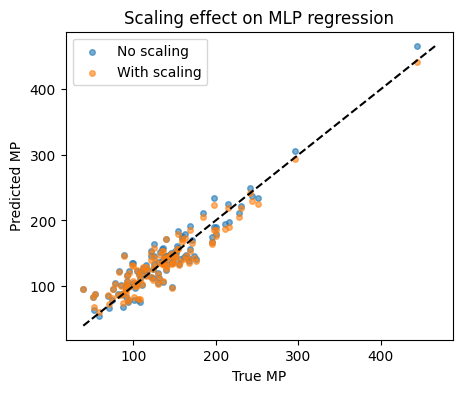

In [13]:
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred_raw, s=16, alpha=0.6, label="No scaling")
plt.scatter(y_test, y_pred_scaled, s=16, alpha=0.6, label="With scaling")
lims = [min(y_test.min(), y_pred_raw.min(), y_pred_scaled.min()),
        max(y_test.max(), y_pred_raw.max(), y_pred_scaled.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP")
plt.ylabel("Predicted MP")
plt.title("Scaling effect on MLP regression")
plt.legend()
plt.show()

**Exercises 4.x**

1. Try a single hidden layer `(32,)` and two layers `(128,64)`. Record R². Which is better here?
2. Change `alpha` to `1e-3` then `1e-2`. This is L2 regularization. How does it change test R² and the gap between train and test?
3. Set `early_stopping=True` and `validation_fraction=0.15`. Compare training time and R².

---

## 5. Regression with MLP on log-solubility

Solubility has a long tail. We saw in Lecture 5 that log transform helped.

### 5.1 Prepare data

In [14]:
df_sol = df.copy()
df_sol = df_sol[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"] + 1e-6)

X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)
Xtr[:3], ytr[:5]

(array([[174.243 ,   2.768 ,  17.07  ,   2.    ],
        [250.725 ,   3.6854,  26.3   ,   3.    ],
        [316.154 ,   3.2662,  46.17  ,   3.    ]]),
 array([-1.33079381, -1.81944953, -1.66573637, -1.73461148, -1.83886568]))

### 5.2 Build the pipeline and fit

We start small then expand.

In [15]:
reg1 = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,),
                         activation="relu",
                         learning_rate_init=0.01,
                         alpha=1e-3,
                         max_iter=1000,
                         random_state=0))
])
reg1

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(alpha=0.001, hidden_layer_sizes=(32,),
                              learning_rate_init=0.01, max_iter=1000,
                              random_state=0))])

In [16]:
reg1.fit(Xtr, ytr)
yhat = reg1.predict(Xte)

print(f"MSE: {mean_squared_error(yte, yhat):.4f}")
print(f"MAE: {mean_absolute_error(yte, yhat):.4f}")
print(f"R2:  {r2_score(yte, yhat):.3f}")

MSE: 0.0185
MAE: 0.1075
R2:  0.966


### 5.3 Parity and residuals

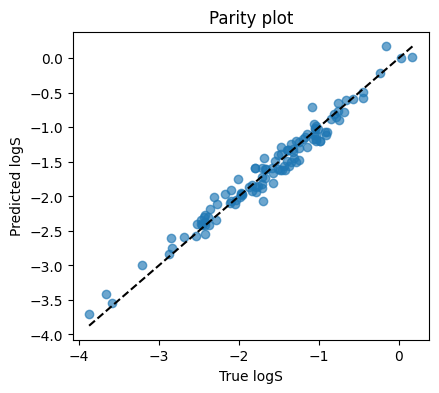

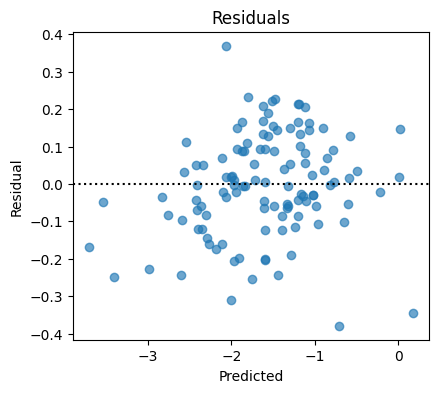

In [17]:
plt.figure(figsize=(4.6,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS")
plt.ylabel("Predicted logS")
plt.title("Parity plot")
plt.show()

resid = yte - yhat
plt.figure(figsize=(4.6,4))
plt.scatter(yhat, resid, alpha=0.65)
plt.axhline(0, color="k", linestyle=":")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

### 5.4 Training curve

`MLPRegressor` exposes `loss_curve_` after fit. This is the average loss per epoch on the training data.

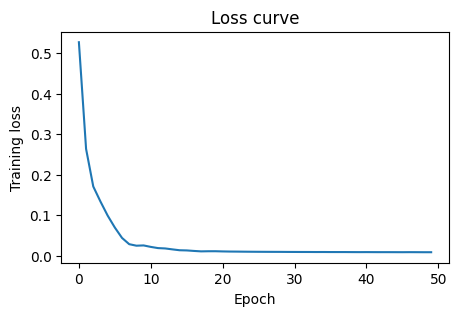

In [18]:
mlp_reg = reg1.named_steps["mlp"]
plt.figure(figsize=(5,3))
plt.plot(mlp_reg.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Loss curve")
plt.show()

**Exercises 5.x**

1. Double the hidden units to `(64,)`. Compare the loss curve and test R².
2. Switch to two layers `(64,32)`. Did you gain anything?
3. Set `early_stopping=True` and keep `max_iter=2000`. Observe whether training stops earlier. Note the final validation score printed by scikit-learn.

---

## 6. Classification with MLP on toxicity

We will predict `toxic` vs `non_toxic` from the same four descriptors.

### 6.1 Prepare labels and split

In [19]:
df_clf = df[["MolWt","LogP","TPSA","NumRings","Toxicity"]].dropna()
label_map = {"toxic":1, "non_toxic":0}
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int).values
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
Xtr.shape, ytr.mean()

((460, 4), 0.8239130434782609)

### 6.2 Build classifier

In [20]:
clf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,),
                          activation="relu",
                          learning_rate_init=0.01,
                          alpha=1e-3,
                          max_iter=2000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          random_state=0))
])
clf_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=0.001, early_stopping=True,
                               hidden_layer_sizes=(32,),
                               learning_rate_init=0.01, max_iter=2000,
                               random_state=0, validation_fraction=0.15))])

Fit and evaluate.

In [21]:
clf_pipe.fit(Xtr, ytr)
yp = clf_pipe.predict(Xte)
yproba = clf_pipe.predict_proba(Xte)[:,1]

acc  = accuracy_score(yte, yp)
prec = precision_score(yte, yp)
rec  = recall_score(yte, yp)
f1   = f1_score(yte, yp)
auc  = roc_auc_score(yte, yproba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")
print(f"AUC:       {auc:.3f}")

Accuracy:  0.896
Precision: 0.946
Recall:    0.926
F1:        0.936
AUC:       0.942


Confusion matrix and ROC.

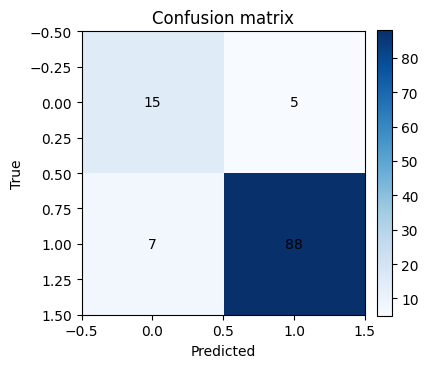

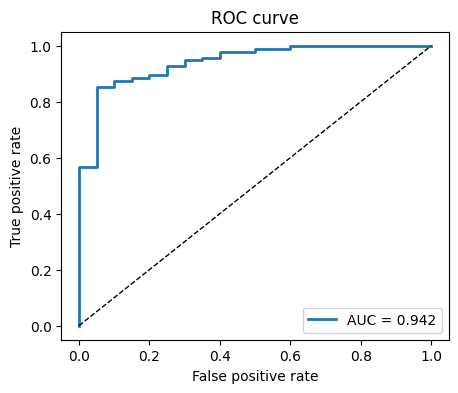

In [22]:
cm = confusion_matrix(yte, yp)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

fpr, tpr, thr = roc_curve(yte, yproba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

Threshold tuning demo.

In [23]:
for t in [0.3, 0.5, 0.7]:
    yp_t = (yproba >= t).astype(int)
    print(f"threshold={t:.2f}  acc={accuracy_score(yte, yp_t):.3f}  prec={precision_score(yte, yp_t):.3f}  rec={recall_score(yte, yp_t):.3f}")

threshold=0.30  acc=0.887  prec=0.887  rec=0.989
threshold=0.50  acc=0.896  prec=0.946  rec=0.926
threshold=0.70  acc=0.878  prec=0.976  rec=0.874


**Exercises 6.x**

1. Change `hidden_layer_sizes` to `(64,)` then `(64,32)` and compare AUC.
2. Try `activation="tanh"` and compare ROC curves.
3. Increase `alpha` to `1e-2`. Did precision or recall change more?

---

## 7. Peek inside the network

While scikit-learn MLP is a black box in training, you can still inspect weights.

We will look at the first layer weights for regression on log-solubility and see which descriptors each hidden unit is sensitive to.

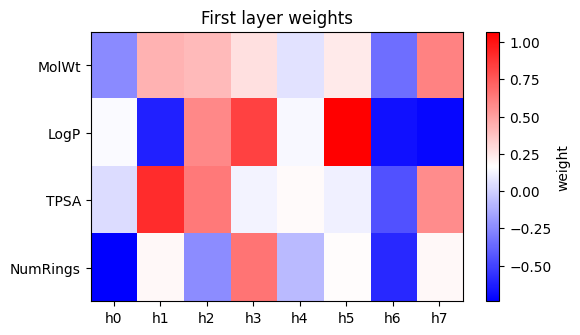

In [24]:
reg_inspect = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(8,),
                         activation="tanh",
                         learning_rate_init=0.01,
                         alpha=1e-3,
                         max_iter=1500,
                         random_state=0))
]).fit(Xtr, ytr)

W1 = reg_inspect.named_steps["mlp"].coefs_[0]  # shape (4, 8)
cols = ["MolWt","LogP","TPSA","NumRings"]

plt.figure(figsize=(6,3.5))
plt.imshow(W1, aspect="auto", cmap="bwr")
plt.yticks(range(len(cols)), cols)
plt.xticks(range(W1.shape[1]), [f"h{j}" for j in range(W1.shape[1])])
plt.colorbar(label="weight")
plt.title("First layer weights")
plt.show()

```{admonition} How to read this
Each column is a hidden unit. Positive weights mean the unit activates when that feature is larger than average. Negative weights mean the opposite. This is not a full explanation, but it gives a flavor of what the network latches onto.
```

---

## 8. Overfitting, regularization, and early stopping

Neural nets can overfit small chemistry tables. Two easy controls:

- **L2 penalty** via `alpha`. Larger alpha shrinks weights.
- **Early stopping** stops when validation score stops improving.

We will show a sweep of `alpha` for log-solubility.

In [25]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2]
scores = []
for a in alphas:
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(64,32),
                             activation="relu",
                             learning_rate_init=0.01,
                             alpha=a,
                             early_stopping=True,
                             validation_fraction=0.15,
                             max_iter=3000,
                             random_state=0))
    ])
    reg.fit(Xtr, ytr)
    yhat = reg.predict(Xte)
    scores.append(r2_score(yte, yhat))

pd.DataFrame({"alpha": alphas, "R2": np.round(scores, 3)})

,alpha,R2
0,0.00001,0.701
1,0.00010,0.699
2,0.00100,0.698
3,0.01000,0.711


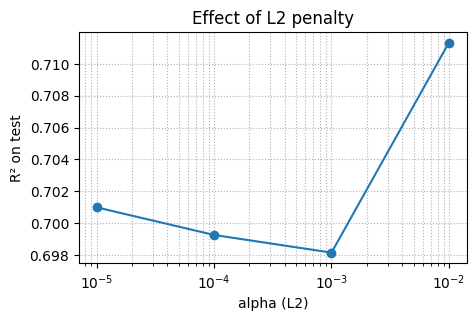

In [26]:
plt.figure(figsize=(5,3))
plt.semilogx(alphas, scores, marker="o")
plt.xlabel("alpha (L2)")
plt.ylabel("R² on test")
plt.title("Effect of L2 penalty")
plt.grid(True, which="both", linestyle=":")
plt.show()

**Exercises 8.x**

1. Fix `alpha=1e-3` and toggle `early_stopping` True vs False. Compare test R² and time.
2. Try `learning_rate_init=0.001` then `0.05`. If training diverges, reduce the rate or raise alpha.

---

## 9. Quick reference

```{admonition} Recipes
- Always scale inputs for MLPs: `Pipeline([("scaler", StandardScaler()), ("mlp", ...)])`
- Start small: one hidden layer with 16 to 64 units
- For regression: check parity and residual plots
- For classification: look at confusion matrix and ROC
- To avoid overfitting: increase `alpha` and use `early_stopping=True`
- Reproducibility: set `random_state`
```

```{admonition} Common args
- `hidden_layer_sizes=(h1, h2, ...)` number of units per layer
- `activation="relu"` or `"tanh"`
- `alpha` L2 penalty, try 1e-5 to 1e-2
- `learning_rate_init` step size, try 0.001 to 0.05
- `max_iter` cap on epochs
- `early_stopping=True` and `validation_fraction=0.1 to 0.2`
```

---

## 10. In-class activity

Each question stands on its own. Most reuse code patterns above.

### Q1. Tiny MLP for melting point

- Use features `[MolWt, LogP, TPSA, NumRings]`
- Split 80/20 with `random_state=7`
- Train `MLPRegressor` with `(32,)`, `alpha=1e-3`, ReLU
- Report `MSE`, `MAE`, `R²` and draw a parity plot

MSE=409.35  MAE=16.27  R2=0.855


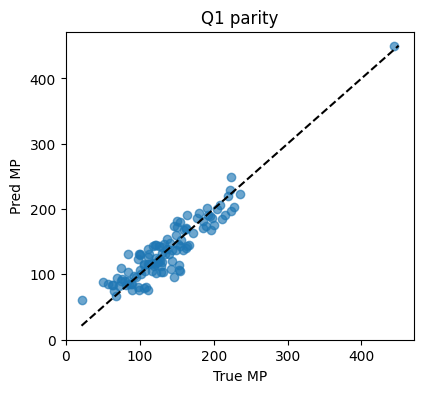

In [27]:
# Q1 starter
df_reg = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values
y = df_reg["Melting Point"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=7)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,),
                         activation="relu",
                         alpha=1e-3,
                         learning_rate_init=0.01,
                         max_iter=1500,
                         random_state=0))
]).fit(Xtr, ytr)

yhat = pipe.predict(Xte)
print(f"MSE={mean_squared_error(yte,yhat):.2f}  MAE={mean_absolute_error(yte,yhat):.2f}  R2={r2_score(yte,yhat):.3f}")

plt.figure(figsize=(4.5,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Q1 parity")
plt.show()

### Q2. Depth vs width on log-solubility

- Train three models on `logS` with hidden sizes `(16,)`, `(32,)`, `(64,32)`
- Keep `alpha=1e-3`, `learning_rate_init=0.01`, early stopping on
- Compare test `R²` and show the three loss curves on the same plot

  hidden_sizes     R2
0        (16,)  0.950
1        (32,)  0.964
2     (64, 32)  0.958


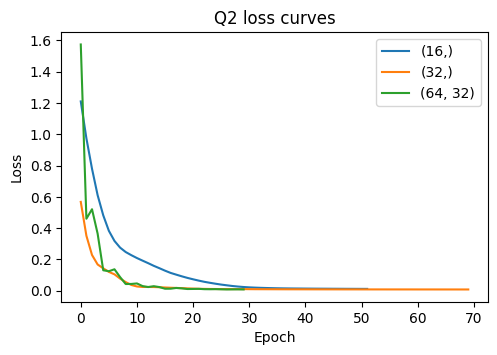

In [28]:
# Q2 starter
sizes = [(16,), (32,), (64,32)]
r2s, curves = [], []

df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

for sz in sizes:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=sz, activation="relu",
                             alpha=1e-3, learning_rate_init=0.01,
                             early_stopping=True, validation_fraction=0.15,
                             max_iter=3000, random_state=0))
    ]).fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    r2s.append(r2_score(yte, yhat))
    curves.append(pipe.named_steps["mlp"].loss_curve_)

print(pd.DataFrame({"hidden_sizes":[str(s) for s in sizes],"R2":np.round(r2s,3)}))

plt.figure(figsize=(5.5,3.5))
for sz, c in zip(sizes, curves):
    plt.plot(c, label=str(sz))
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Q2 loss curves")
plt.legend(); plt.show()

### Q3. Toxicity classification with threshold tuning

- Train `MLPClassifier` with `(32,)`, `alpha=1e-3`, early stopping on
- Compute probabilities on test
- For thresholds `[0.3, 0.5, 0.7]` print Accuracy, Precision, Recall, F1

In [29]:
# Q3 starter
df_clf = df[["MolWt","LogP","TPSA","NumRings","Toxicity"]].dropna()
y = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).astype(int).values
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,),
                          activation="relu",
                          alpha=1e-3, learning_rate_init=0.01,
                          early_stopping=True, validation_fraction=0.15,
                          max_iter=3000, random_state=0))
]).fit(Xtr, ytr)

proba = clf.predict_proba(Xte)[:,1]
for t in [0.3, 0.5, 0.7]:
    pred = (proba >= t).astype(int)
    print(f"t={t:.1f}  acc={accuracy_score(yte,pred):.3f}  prec={precision_score(yte,pred):.3f}  rec={recall_score(yte,pred):.3f}  f1={f1_score(yte,pred):.3f}")

t=0.3  acc=0.887  prec=0.887  rec=0.989  f1=0.935
t=0.5  acc=0.896  prec=0.946  rec=0.926  f1=0.936
t=0.7  acc=0.878  prec=0.976  rec=0.874  f1=0.922


### Q4. Compare MLP to Linear Regression on logS

- Same train test split as Q2
- Fit Linear Regression on scaled inputs
- Report both R² on test and draw both parity scatters on one plot

Linear R2: 0.324
MLP    R2: 0.520


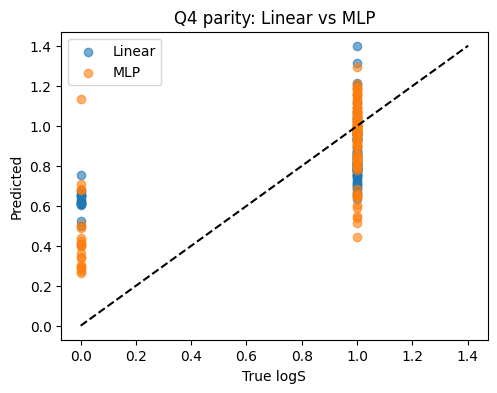

In [30]:
# Q4 starter
sc = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = sc.transform(Xtr), sc.transform(Xte)

lr = LinearRegression().fit(Xtr_s, ytr)
yhat_lr = lr.predict(Xte_s)

best_idx = int(np.argmax(r2s))
yhat_mlp = Pipeline([("scaler", sc), ("mlp", MLPRegressor(hidden_layer_sizes=sizes[best_idx],
                                                          activation="relu", alpha=1e-3,
                                                          max_iter=3000, random_state=0))]).fit(Xtr, ytr).predict(Xte)

print(f"Linear R2: {r2_score(yte, yhat_lr):.3f}")
print(f"MLP    R2: {r2_score(yte, yhat_mlp):.3f}")

plt.figure(figsize=(5.5,4))
plt.scatter(yte, yhat_lr, alpha=0.6, label="Linear")
plt.scatter(yte, yhat_mlp, alpha=0.6, label="MLP")
lims = [min(yte.min(), yhat_lr.min(), yhat_mlp.min()), max(yte.max(), yhat_lr.max(), yhat_mlp.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Predicted")
plt.legend(); plt.title("Q4 parity: Linear vs MLP")
plt.show()

### Q5. Stability across seeds

- Fix model `MLPRegressor(hidden_layer_sizes=(32,), alpha=1e-3)`
- Run with `random_state` in `[0, 7, 21, 42, 77]`
- Report test R² for each and plot a small line chart

   seed     R2
0     0  0.691
1     7  0.686
2    21  0.658
3    42  0.657
4    77  0.716


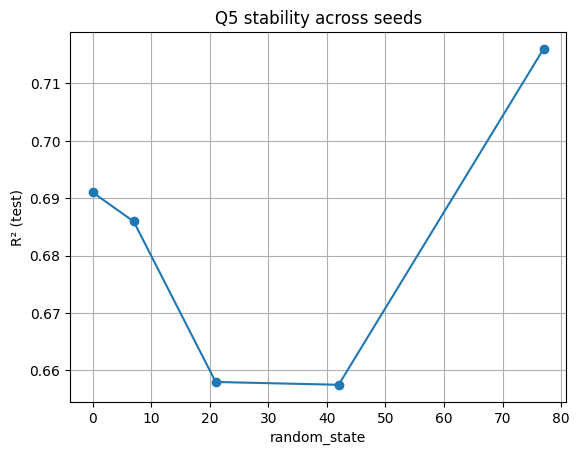

In [31]:
# Q5 starter
seeds = [0, 7, 21, 42, 77]
r2_list = []
for s in seeds:
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(32,), activation="relu",
                             alpha=1e-3, learning_rate_init=0.01,
                             early_stopping=True, validation_fraction=0.15,
                             max_iter=3000, random_state=s))
    ]).fit(Xtr, ytr)
    r2_list.append(r2_score(yte, reg.predict(Xte)))

print(pd.DataFrame({"seed": seeds, "R2": np.round(r2_list,3)}))

plt.plot(seeds, r2_list, "o-")
plt.xlabel("random_state"); plt.ylabel("R² (test)")
plt.title("Q5 stability across seeds")
plt.grid(True); plt.show()

---

## 11. Solutions

### Solution Q1

MSE=409.35  MAE=16.27  R2=0.855


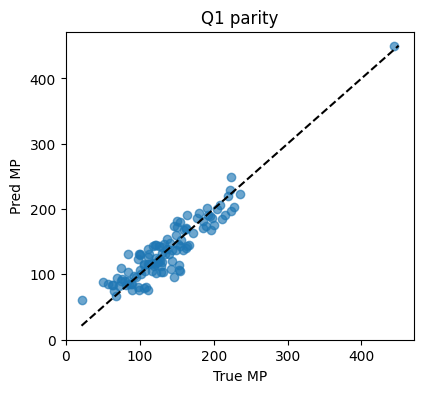

In [32]:
df_reg = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values
y = df_reg["Melting Point"].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=7)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,), activation="relu",
                         alpha=1e-3, learning_rate_init=0.01,
                         max_iter=1500, random_state=0))
]).fit(Xtr, ytr)

yhat = pipe.predict(Xte)
print(f"MSE={mean_squared_error(yte,yhat):.2f}  MAE={mean_absolute_error(yte,yhat):.2f}  R2={r2_score(yte,yhat):.3f}")

plt.figure(figsize=(4.5,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Q1 parity")
plt.show()

### Solution Q2

  hidden_sizes     R2
0        (16,)  0.950
1        (32,)  0.964
2     (64, 32)  0.958


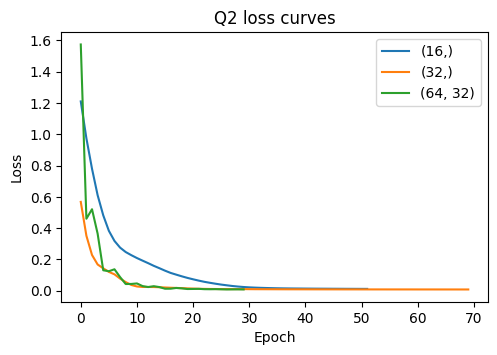

In [33]:
sizes = [(16,), (32,), (64,32)]
df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

r2s, curves = [], []
for sz in sizes:
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=sz, activation="relu",
                             alpha=1e-3, learning_rate_init=0.01,
                             early_stopping=True, validation_fraction=0.15,
                             max_iter=3000, random_state=0))
    ]).fit(Xtr, ytr)
    yhat = reg.predict(Xte)
    r2s.append(r2_score(yte, yhat))
    curves.append(reg.named_steps["mlp"].loss_curve_)

print(pd.DataFrame({"hidden_sizes":[str(s) for s in sizes],"R2":np.round(r2s,3)}))

plt.figure(figsize=(5.5,3.5))
for sz, c in zip(sizes, curves):
    plt.plot(c, label=str(sz))
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Q2 loss curves")
plt.legend(); plt.show()

### Solution Q3

In [34]:
df_clf = df[["MolWt","LogP","TPSA","NumRings","Toxicity"]].dropna()
y = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).astype(int).values
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,), activation="relu",
                          alpha=1e-3, learning_rate_init=0.01,
                          early_stopping=True, validation_fraction=0.15,
                          max_iter=3000, random_state=0))
]).fit(Xtr, ytr)

proba = clf.predict_proba(Xte)[:,1]
for t in [0.3, 0.5, 0.7]:
    pred = (proba >= t).astype(int)
    print(f"t={t:.1f}  acc={accuracy_score(yte,pred):.3f}  prec={precision_score(yte,pred):.3f}  rec={recall_score(yte,pred):.3f}  f1={f1_score(yte,pred):.3f}")

t=0.3  acc=0.887  prec=0.887  rec=0.989  f1=0.935
t=0.5  acc=0.896  prec=0.946  rec=0.926  f1=0.936
t=0.7  acc=0.878  prec=0.976  rec=0.874  f1=0.922


### Solution Q4

Linear R2: 0.970
MLP    R2: 0.966


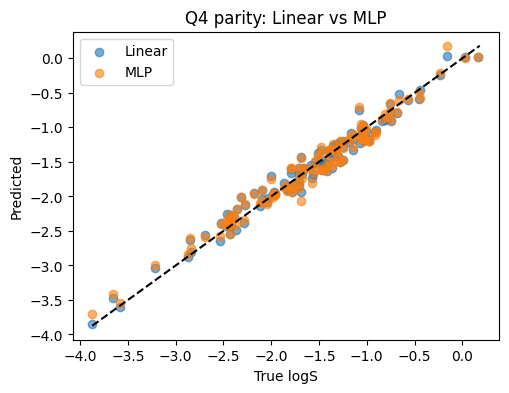

In [35]:
df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

sc = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = sc.transform(Xtr), sc.transform(Xte)

lr = LinearRegression().fit(Xtr_s, ytr)
yhat_lr = lr.predict(Xte_s)

mlp = MLPRegressor(hidden_layer_sizes=(32,), activation="relu",
                   alpha=1e-3, learning_rate_init=0.01,
                   max_iter=3000, random_state=0).fit(Xtr_s, ytr)
yhat_mlp = mlp.predict(Xte_s)

print(f"Linear R2: {r2_score(yte, yhat_lr):.3f}")
print(f"MLP    R2: {r2_score(yte, yhat_mlp):.3f}")

plt.figure(figsize=(5.5,4))
plt.scatter(yte, yhat_lr, alpha=0.6, label="Linear")
plt.scatter(yte, yhat_mlp, alpha=0.6, label="MLP")
lims = [min(yte.min(), yhat_lr.min(), yhat_mlp.min()), max(yte.max(), yhat_lr.max(), yhat_mlp.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Predicted")
plt.legend(); plt.title("Q4 parity: Linear vs MLP")
plt.show()

### Solution Q5

   seed     R2
0     0  0.964
1     7  0.962
2    21  0.965
3    42  0.964
4    77  0.961


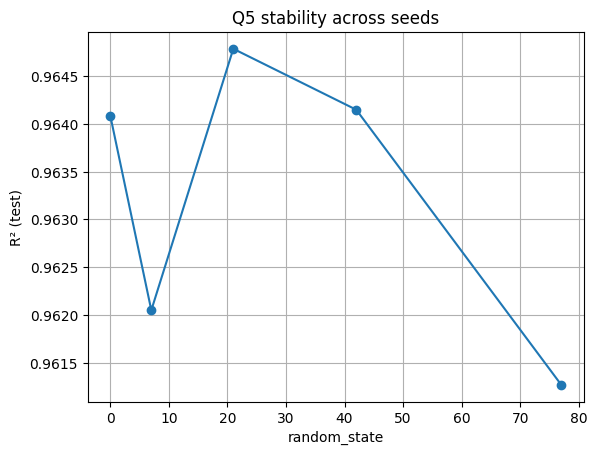

In [36]:
df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

seeds = [0, 7, 21, 42, 77]
r2_list = []
for s in seeds:
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(32,), activation="relu",
                             alpha=1e-3, learning_rate_init=0.01,
                             early_stopping=True, validation_fraction=0.15,
                             max_iter=3000, random_state=s))
    ]).fit(Xtr, ytr)
    r2_list.append(r2_score(yte, reg.predict(Xte)))

print(pd.DataFrame({"seed": seeds, "R2": np.round(r2_list,3)}))

plt.plot(seeds, r2_list, "o-")
plt.xlabel("random_state"); plt.ylabel("R² (test)")
plt.title("Q5 stability across seeds")
plt.grid(True); plt.show()

---

## 12. Glossary

```{glossary}
multilayer perceptron
  A network of layers that apply linear transforms plus nonlinear activations.

activation
  Nonlinear function applied elementwise. Common choices: ReLU, tanh, logistic.

loss
  A number that measures how wrong the predictions are on training data.

optimizer
  Method that updates weights to reduce loss. Scikit-learn uses variants of SGD or LBFGS under the hood.

alpha
  L2 penalty strength in scikit-learn MLP. Larger means more shrinkage.

early stopping
  Stop training when validation score does not improve for a patience window.

scaling
  Standardize features to zero mean and unit variance. Critical for neural nets.

parity plot
  Scatter of predicted vs true values for regression.

ROC AUC
  Area under the Receiver Operating Characteristic curve. Threshold free ranking metric.

hidden layer
  A layer between input and output that lets the model learn nonlinear combinations.
```

---

## 13. Optional: a Keras taste (run only if TensorFlow is available)

This is not required for our class, but if `tensorflow` is installed, you can try a tiny Keras model on log-solubility. If import fails, skip.

In [37]:
try:
    import tensorflow as tf
    from tensorflow import keras
    from sklearn.compose import ColumnTransformer

    # Data
    df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
    df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
    X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values.astype("float32")
    y = df_sol["logS"].values.astype("float32")
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

    # Scale
    sc = StandardScaler().fit(Xtr)
    Xtr_s = sc.transform(Xtr).astype("float32")
    Xte_s = sc.transform(Xte).astype("float32")

    # Model
    model = keras.Sequential({
        "layers": [
            keras.layers.Input(shape=(4,)),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1)
        ]
    })
    model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="mse", metrics=["mae"])
    history = model.fit(Xtr_s, ytr, validation_split=0.15, epochs=200, verbose=0)
    yhat = model.predict(Xte_s).ravel()
    print("Keras R2:", r2_score(yte, yhat))

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend(); plt.title("Keras training")
    plt.show()
except Exception as e:
    print("TensorFlow not available here. This optional demo is skipped.")

TensorFlow not available here. This optional demo is skipped.


---

## 14. Moving forward with PyTorch

```{admonition} Why try PyTorch
You have trained MLPs with scikit-learn. PyTorch lets you write the forward pass directly, control the training loop, and later move to GPUs or custom layers. We start tiny and stay friendly.
```

### 14.1 Setup

In [38]:
# Optional install in hosted environments
try:
    import torch, torch.nn as nn, torch.utils.data as tud
except Exception:
    try:
        %pip install torch --quiet
    except Exception as e:
        print("If torch is missing, install it in your environment: pip install torch")
    import torch, torch.nn as nn, torch.utils.data as tud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

We will reuse the same descriptors from earlier. If RDKit was not available above, we will only use precomputed numeric columns.

In [39]:
# Reuse df from earlier sections if defined. If not, load again.
if 'df' not in globals():
    url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
    df_raw = pd.read_csv(url)
    try:
        from rdkit import Chem
        from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
        def calc_desc(smiles):
            m = Chem.MolFromSmiles(smiles)
            if m is None:
                return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
            return pd.Series({
                "MolWt": Descriptors.MolWt(m),
                "LogP": Crippen.MolLogP(m),
                "TPSA": rdMolDescriptors.CalcTPSA(m),
                "NumRings": rdMolDescriptors.CalcNumRings(m)
            })
        desc = df_raw["SMILES"].apply(calc_desc)
        df = pd.concat([df_raw, desc], axis=1)
    except Exception:
        df = df_raw.copy()

---

### 14.2 PyTorch regression on log-solubility

#### 14.2.1 Prepare arrays and scale

In [40]:
df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"] + 1e-6)

X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)
y = df_sol["logS"].values.astype(np.float32).reshape(-1,1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=15)

sc = StandardScaler().fit(X_tr)
X_tr_s = sc.transform(X_tr).astype(np.float32)
X_te_s = sc.transform(X_te).astype(np.float32)

X_tr_s[:2], y_tr[:2]

(array([[-0.52517456, -0.14637874, -0.51305276, -0.18582454],
        [ 0.282102  ,  0.38910738, -0.21582305,  0.49258253]],
       dtype=float32),
 array([[-1.3307939],
        [-1.8194495]], dtype=float32))

```{admonition} Exercise A
Change the split to `test_size=0.1` and `random_state=7`. Record the new R² at the end of training and compare.
```

#### 14.2.2 Build `Dataset` and `DataLoader`

In [41]:
class NumpyDataset(tud.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_tr_s, y_tr)
test_ds  = NumpyDataset(X_te_s, y_te)

train_loader = tud.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = tud.DataLoader(test_ds, batch_size=256, shuffle=False)

len(train_ds), len(test_ds)

(460, 115)

```{admonition} Exercise B
Try `batch_size=16` and then `batch_size=128`. Watch the loss curve and the final R². Which is smoother, which is faster?
```

#### 14.2.3 Define a tiny MLP

In [42]:
in_dim = X_tr_s.shape[1]
model = nn.Sequential(
    nn.Linear(in_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
model

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)

```{admonition} Exercise C
Increase hidden units to 64, or add a second hidden layer `nn.Linear(64, 32)` with another `nn.ReLU()`. Keep all else the same and compare R².
```

#### 14.2.4 Loss and optimizer

In [43]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)  # weight_decay is L2
lr = 1e-2

#### 14.2.5 Train for a few epochs

We will log the mean batch loss per epoch to see progress.

epoch   25  train_loss 0.0178


epoch   50  train_loss 0.0165


epoch   75  train_loss 0.0164


epoch  100  train_loss 0.0159


epoch  125  train_loss 0.0170


epoch  150  train_loss 0.0150


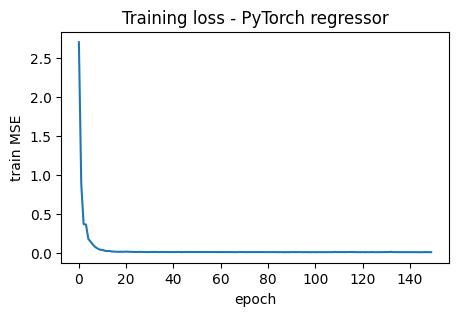

In [44]:
train_losses = []
epochs = 150

for epoch in range(1, epochs+1):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))
    if epoch % 25 == 0:
        print(f"epoch {epoch:4d}  train_loss {train_losses[-1]:.4f}")

plt.figure(figsize=(5,3))
plt.plot(train_losses)
plt.xlabel("epoch"); plt.ylabel("train MSE")
plt.title("Training loss - PyTorch regressor")
plt.show()

```{admonition} Tip
If the curve jiggles or rises, reduce `lr` to `5e-3` or raise `weight_decay` to `5e-3`.
```

#### 14.2.6 Evaluate on test

In [45]:
model.eval()
with torch.no_grad():
    yhat_te = model(torch.from_numpy(X_te_s)).cpu().numpy()

print(f"MSE: {mean_squared_error(y_te, yhat_te):.4f}")
print(f"MAE: {mean_absolute_error(y_te, yhat_te):.4f}")
print(f"R2:  {r2_score(y_te, yhat_te):.3f}")

MSE: 0.0176
MAE: 0.1050
R2:  0.967


Parity and residuals.

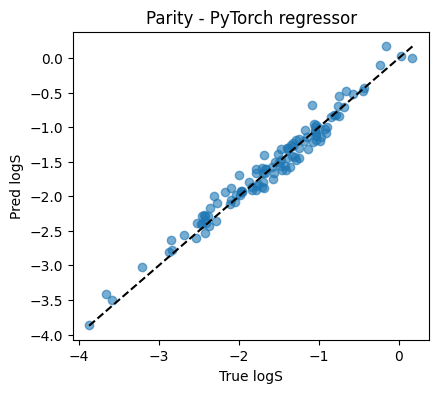

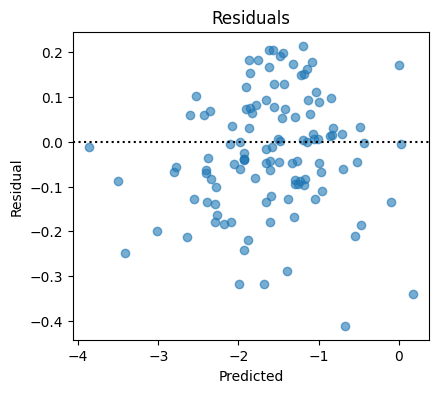

In [46]:
plt.figure(figsize=(4.6,4))
plt.scatter(y_te, yhat_te, alpha=0.6)
lims = [min(y_te.min(), yhat_te.min()), max(y_te.max(), yhat_te.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Pred logS")
plt.title("Parity - PyTorch regressor")
plt.show()

res = y_te - yhat_te
plt.figure(figsize=(4.6,4))
plt.scatter(yhat_te, res, alpha=0.6)
plt.axhline(0, color="k", linestyle=":")
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

---

### 14.3 PyTorch classification on toxicity

We will predict toxic vs non_toxic using a one-output network with `BCEWithLogitsLoss` which expects raw scores (logits).

#### 14.3.1 Prepare labels and loaders

In [47]:
df_clf = df[["MolWt","LogP","TPSA","NumRings","Toxicity"]].dropna().copy()
y_cls = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).astype(np.float32).values.reshape(-1,1)
X_cls = df_clf[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)

Xtr, Xte, ytr, yte = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls.ravel())

sc_c = StandardScaler().fit(Xtr)
Xtr_s = sc_c.transform(Xtr).astype(np.float32)
Xte_s = sc_c.transform(Xte).astype(np.float32)

train_ds_c = NumpyDataset(Xtr_s, ytr)
test_ds_c  = NumpyDataset(Xte_s, yte)
train_loader_c = tud.DataLoader(train_ds_c, batch_size=64, shuffle=True)
test_loader_c  = tud.DataLoader(test_ds_c, batch_size=256, shuffle=False)

Xtr_s[:2], ytr[:2].ravel()

(array([[ 0.907901  ,  1.0488356 , -0.5002361 ,  1.1444418 ],
        [-1.0144128 , -0.5859274 , -0.25169975, -1.5043292 ]],
       dtype=float32),
 array([1., 0.], dtype=float32))

#### 14.3.2 Define model, loss, optimizer

In [48]:
clf_torch = nn.Sequential(
    nn.Linear(4, 32),
    nn.ReLU(),
    nn.Linear(32, 1)   # one logit
)
loss_bce = nn.BCEWithLogitsLoss()
opt_c = torch.optim.Adam(clf_torch.parameters(), lr=5e-3, weight_decay=1e-3)

#### 14.3.3 Train and track loss

epoch   30  loss 0.1285


epoch   60  loss 0.1199


epoch   90  loss 0.1268


epoch  120  loss 0.1372


epoch  150  loss 0.1178


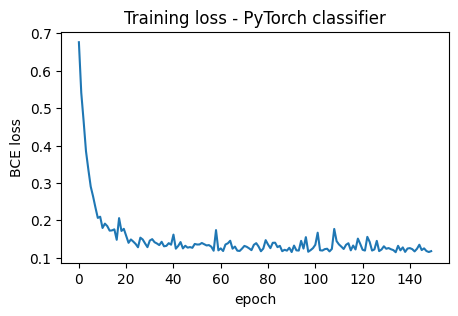

In [49]:
losses_c = []
for epoch in range(1, 151):
    clf_torch.train()
    epoch_loss = 0.0
    for xb, yb in train_loader_c:
        logits = clf_torch(xb)
        loss = loss_bce(logits, yb)
        opt_c.zero_grad()
        loss.backward()
        opt_c.step()
        epoch_loss += loss.item()
    losses_c.append(epoch_loss / len(train_loader_c))
    if epoch % 30 == 0:
        print(f"epoch {epoch:4d}  loss {losses_c[-1]:.4f}")

plt.figure(figsize=(5,3))
plt.plot(losses_c)
plt.xlabel("epoch"); plt.ylabel("BCE loss")
plt.title("Training loss - PyTorch classifier")
plt.show()

#### 14.3.4 Evaluate, threshold, ROC

In [50]:
clf_torch.eval()
with torch.no_grad():
    logits = clf_torch(torch.from_numpy(Xte_s)).cpu().numpy().ravel()
proba = 1 / (1 + np.exp(-logits))  # sigmoid

# default threshold 0.5
pred = (proba >= 0.5).astype(int)
acc = accuracy_score(yte.ravel(), pred)
prec = precision_score(yte.ravel(), pred)
rec = recall_score(yte.ravel(), pred)
f1 = f1_score(yte.ravel(), pred)
auc = roc_auc_score(yte.ravel(), proba)
print(f"Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")

Accuracy=0.939  Precision=0.968  Recall=0.958  F1=0.963  AUC=0.987


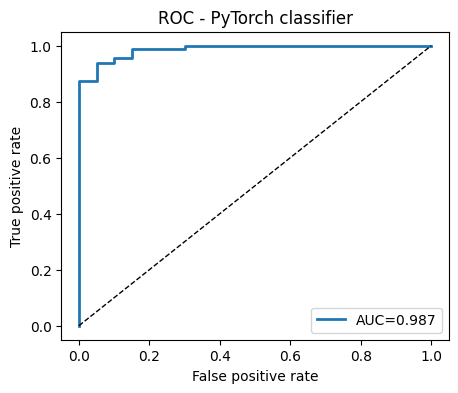

t=0.3  acc=0.939  prec=0.940  rec=0.989  f1=0.964
t=0.5  acc=0.939  prec=0.968  rec=0.958  f1=0.963
t=0.7  acc=0.939  prec=0.978  rec=0.947  f1=0.963


In [51]:
fpr, tpr, thr = roc_curve(yte.ravel(), proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC - PyTorch classifier")
plt.legend()
plt.show()

for t in [0.3, 0.5, 0.7]:
    p = (proba >= t).astype(int)
    print(f"t={t:.1f}  acc={accuracy_score(yte,p):.3f}  prec={precision_score(yte,p):.3f}  rec={recall_score(yte,p):.3f}  f1={f1_score(yte,p):.3f}")

```{admonition} Exercise D
Swap `nn.ReLU()` for `nn.Tanh()` and retrain. Which threshold gives the best F1 now?
```

---

### 14.4 Save, load, and predict new molecules

In [52]:
# Save
torch.save(model.state_dict(), "pytorch_reg_logS.pt")
# Load into a fresh instance with same architecture
model2 = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,1))
model2.load_state_dict(torch.load("pytorch_reg_logS.pt"))
model2.eval()

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)

Predict for two descriptor rows. Use the same scaler.

In [53]:
X_new = np.array([[135.0, 2.0,  9.2, 2],
                  [301.0, 0.5, 17.7, 2]], dtype=np.float32)
X_new_s = sc.transform(X_new).astype(np.float32)

with torch.no_grad():
    y_new = model2(torch.from_numpy(X_new_s)).cpu().numpy().ravel()

pd.DataFrame({"MolWt":[135.0,301.0],"LogP":[2.0,0.5],"TPSA":[9.2,17.7],"NumRings":[2,2],"Pred logS": y_new})

,MolWt,LogP,TPSA,NumRings,Pred logS
0,135.0,2.0,9.2,2,-1.140618
1,301.0,0.5,17.7,2,-0.245693


---

### 14.5 Mini in-class activity - PyTorch

Complete the tasks using the code above. Fill the `...` where shown.

#### Q1. Two hidden layers for logS

- Model: 64 then 32 units, ReLU
- Train 200 epochs, `lr=1e-2`, `weight_decay=1e-3`
- Report test R²

In [54]:
# Q1 starter
reg2 = nn.Sequential(
    nn.Linear(4, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 1)
)
opt = torch.optim.Adam(reg2.parameters(), lr=1e-2, weight_decay=1e-3)
for ep in range(200):
    reg2.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        loss = nn.MSELoss()(reg2(xb), yb)
        loss.backward(); opt.step()

reg2.eval()
with torch.no_grad():
    yhat = reg2(torch.from_numpy(X_te_s)).cpu().numpy()
print(f"R2: {r2_score(y_te, yhat):.3f}")

R2: 0.964


#### Q2. Early stop by validation split

- Use 15 percent of train as validation
- Stop if val loss does not improve for 20 epochs
- Report epoch stopped and test R²

In [55]:
# Q2 starter
X_tr_s, X_val_s, y_tr_, y_val_ = train_test_split(X_tr_s, y_tr, test_size=0.15, random_state=0)
train_ds2 = NumpyDataset(X_tr_s, y_tr_)
val_ds2   = NumpyDataset(X_val_s, y_val_)
train_loader2 = tud.DataLoader(train_ds2, batch_size=64, shuffle=True)
val_loader2   = tud.DataLoader(val_ds2, batch_size=256, shuffle=False)

net = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,1))
opt2 = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-3)
best_val, patience, wait = np.inf, 20, 0
best_state = None
for ep in range(1000):
    net.train()
    for xb, yb in train_loader2:
        opt2.zero_grad()
        loss = nn.MSELoss()(net(xb), yb)
        loss.backward(); opt2.step()
    # val
    net.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb, yb in val_loader2:
            vloss += nn.MSELoss()(net(xb), yb).item()
        vloss /= len(val_loader2)
    if vloss < best_val - 1e-5:
        best_val, wait, best_state = vloss, 0, {k:v.clone() for k,v in net.state_dict().items()}
    else:
        wait += 1
    if wait >= patience:
        print(f"Stopped at epoch {ep+1}, best val loss {best_val:.4f}")
        break

if best_state is not None:
    net.load_state_dict(best_state)

with torch.no_grad():
    yhat = net(torch.from_numpy(X_te_s)).cpu().numpy()
print(f"Test R2: {r2_score(y_te, yhat):.3f}")

Stopped at epoch 46, best val loss 0.0162
Test R2: 0.966


#### Q3. Weight decay sweep

- Train three runs with `weight_decay` in `[0.0, 1e-4, 1e-3]`
- Keep `lr=1e-2`, 150 epochs
- Report test R² for each

In [56]:
# Q3 starter
decays = [0.0, 1e-4, 1e-3]
for wd in decays:
    net = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,1))
    opt = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=wd)
    for ep in range(150):
        for xb, yb in train_loader:
            opt.zero_grad()
            loss = nn.MSELoss()(net(xb), yb)
            loss.backward(); opt.step()
    with torch.no_grad():
        r2 = r2_score(y_te, net(torch.from_numpy(X_te_s)).cpu().numpy())
    print(f"weight_decay={wd:g}  R2={r2:.3f}")

weight_decay=0  R2=0.969


weight_decay=0.0001  R2=0.968


weight_decay=0.001  R2=0.967


#### Q4. Toxicity threshold by F1

- Use the classifier from 14.3
- Search thresholds from 0.1 to 0.9 step 0.05
- Print the threshold that maximizes F1 on test

In [57]:
# Q4 starter
ts = np.arange(0.1, 0.91, 0.05)
best_t, best_f1 = 0.5, -1
for t in ts:
    p = (proba >= t).astype(int)
    f1v = f1_score(yte.ravel(), p)
    if f1v > best_f1:
        best_f1, best_t = f1v, t
print(f"Best threshold {best_t:.2f}  F1={best_f1:.3f}")

Best threshold 0.35  F1=0.979


#### Q5. Compare PyTorch vs scikit-learn on logS

- Train the PyTorch regressor from 14.2
- Train `MLPRegressor(hidden_layer_sizes=(32,), alpha=1e-3)` on the same split
- Report both R²

In [58]:
# Q5 starter
from sklearn.neural_network import MLPRegressor

# PyTorch
net = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,1))
opt = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-3)
for ep in range(150):
    for xb, yb in train_loader:
        opt.zero_grad(); loss = nn.MSELoss()(net(xb), yb); loss.backward(); opt.step()
with torch.no_grad():
    r2_torch = r2_score(y_te, net(torch.from_numpy(X_te_s)).cpu().numpy())

# scikit
mlp = MLPRegressor(hidden_layer_sizes=(32,), alpha=1e-3, learning_rate_init=0.01, max_iter=2000, random_state=0).fit(X_tr_s, y_tr.ravel())
r2_skl = r2_score(y_te.ravel(), mlp.predict(X_te_s))

print(f"PyTorch R2: {r2_torch:.3f}  |  scikit-learn R2: {r2_skl:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [391, 460]

---

### 14.6 Mini solutions

- **Q1**: see the Q1 cell for a working two-layer net. You should see R² change relative to the one-layer model.
- **Q2**: early stopping should trigger well before 1000 epochs on this dataset. Report the epoch and test R² as printed.
- **Q3**: moderate `weight_decay` often improves test R². Your printout shows which value is best here.
- **Q4**: the loop prints the best threshold by F1. Keep in mind that the best threshold for F1 may not be best for AUC.
- **Q5**: both models should land in a similar R² range if scaling and capacity match.

```{admonition} Summary
You now have the full path: scikit-learn for quick models, PyTorch for flexible training loops. The same chem descriptors flow into either tool. Keep inputs scaled, watch curves, and use regularization when data is small.
```